# Deep Q-Network

Aqui faremos a adaptação do algoritmo de Q-Learning com a utilização de redes neurais, assim como feito na implementação da DeepMind: https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning

Aconselhemos a leitura da nossa implementação de Q-Learning caso você não esteja tão acostumado com o algoritmo original e os conceitos básicos, pois isso facilitará seu entendimento de uma **DQN** (abreviação de Deep Q-Network). 

## Motivação

Por que "deep"? Ou, por que aprendizado "profundo"?

Q-Learning por si só já é um algoritmo simples e relativamente eficiente para muitos ambientes, mas o que acontece se nosso ambiente for muito grande? E se precisarmos de uma tabela com milhares de estados e ações? 


Será que nosso agente consegue passar por todas as possibilidades de estados e ações para ter uma boa estimativa do Q-Learning? E mais ainda, será que nosso agente **precisa** passar por todos várias vezes?

O uso de **redes neurais** nesse algoritmo veio para que consigamos aproximar Q-Valores a partir de outros estados e ações e assim não precisamos salvar o valor específico de cada configuração.

## Teoria

Então, basicamente, vamos sintetizar a diferença do Q-Learning para DQN:

<img src="imgs/Tabela-NN.png"/>

### Q-Learning

- Criamos uma tabela-Q
- Para cada configuração de **Estado/Ação** armazenamos a estimativa do nosso agente do **Q-valor**

### DQN

- Criamos uma rede neural com **N-estados** neurônios de entrada e **N-ações** neurônios de saída
- Colocamos camadas escondidas de acordo com nossa implementação
- A rede recebe o estado e tenta predizer o **Q-valor** para cada ação disponível

A função *loss* será o **erro quadrático médio** entre Q-valor estimado pela rede e o valor real, entretando, por se tratar de um problema de aprendizado por reforço, **não temos o valor real!**. Assim, usamos outra estimativa para o valor real, o que chamamos de *bootstrap*. 

Assim temos:
- Predição: $Q(S_t, A_t)$
- Target: $max_a Q(S_{t+1}, a)$

E nossa função fica, assim como já visto em Q-Learning:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma max_a Q(S_{t+1}, a) - Q(S_t, A_t)]
$$

### Experience Replay 

Pelo jeito que as redes neurais "aprendem", não é muito eficiente passar os dados coletados pelo agente enquanto ele explora o ambiente, é mais efetivo que nosso agente colete várias experiências e, após termos muitos dados, ir "alimentando" nossa rede. 

Esse tipo de aprendizado é chamado de **off-policy**, porque ele não acontece ao mesmo tempo em que nosso agente explora o ambiente.

Aqui nós utilizaremos o **Experience Replay**, em que armazemos as experiências do nosso agente na forma $(s_t, a_t, r_t, s_{t+1})$, ou seja, o **estado** $s_t$ em que ele estava, a **ação** $a_t$ que ele tomou naquele estado, a **recompensa** $r_t$ que ele recebeu por tomar aquela ação naquele estado e o **próximo estado** $s_{t+1}$ que o agente foi após aquela ação.

Após coletarmos um certo número dessas tuplas $(s_t, a_t, r_t, s_{t+1})$, nós passamos aleatoriamente esses dados para a rede aprender.

## Importações

Aqui faremos a implementação com ```pytorch```, além de usar algumas das bibliotecas mais comuns. O motivo de importarmos Pillow e torchvision é para a implementação da DQN com ConvNet, que está implementada mas não usaremos neste notebook.

In [31]:
import sys
import gym
import math
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

Abaixo vamos importar a classe de Replay Buffer, muito importante para DQN's, que você pode ver a implementação no nosso repositório em Aprendizado por Reforço Profundo -> Deep Q-Learning -> Experience Replay -> ExperienceReplay.ipynb 

A organização da pasta é a seguinte:
```
/
+-- Deep Q-Network
    +-- DQN.ipynb
+-- Experience Replay
    +-- ReplayBuffer.py
```

In [21]:
# Código necessário para importar funções de outro arquivo de um diretório diferente
sys.path.insert(1, '../Experience Replay')
from ReplayBuffer import ReplayBuffer

## Rede Neural

Aqui implementamos uma rede neural linear para servir como nossa DQN, ela é útil para ambientes em que você não está recebendo a imagem como estado do seu problema.

O tamanho da entrada da rede, ou seja, o que nossa rede recebe de ```input``` são os estados disponíveis do ambiente, o ```shape```do estado, assim, é este valor que deverá ser passado em ```in_dim```.

A saída da nossa rede é o **Q-valor** para cada ação disponível, assim, o tamanho de saída é o ```shape``` do estado de ações, que aqui está como ```out_dim```.

O tamanho das camadas escondidas é arbitrário, pode ser variado de uma aplicação para outra e é um dos parâmetros que valem a pena ser modificados para garantir uma maior eficiência da sua rede.

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LinearNetwork(nn.Module):
    """
    Cria uma rede neural para DQN
    """
    def __init__(self, in_dim, out_dim):
        """
        Inicializa a rede
        
        Parâmetros
        ----------
        in_dim: int
        Dimensão de entrada da rede, ou seja, o shape do estado do ambiente
        
        out_dim: int
        Número de ações do agente neste ambiente
        
        Retorna
        -------
        None
        """
        super(LinearNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 64), 
            nn.ReLU(),
            nn.Linear(64, 64), 
            nn.ReLU(), 
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        """
        Propaga uma entrada pela rede
        """
        return self.layers(x)

Também temos implementado uma rede convolucional, para o caso em que seu estado sera uma imagem, mas não a usaremos neste notebook.

O funcionamento é similar, a saída segue o mesmo padrão, mas na entrada deve ser inserido o tamanho da imagem do frame da sua aplicação, assim como garantir que o número de canais está certo.

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ConvNetwork(nn.Module):
    
    def __init__(self, in_channels, h, w, outputs):
        """
        Cria uma rede convolucional 
        
        in_channels: int
        Shape do estado do ambiente
        
        h: int
        A altura da imagem
        
        w: int
        A largura da imagem
        
        outputs: int
        Número de ações do agente neste ambiente
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            """
            Calcula o tamanho de saída da rede conv
            """
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)   
        
    def forward(self, x):
        """
        Faz a forward propagation pela rede
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Agente DQN

Assim como a maioria das aplicações famosas de aprendizado por reforço, uma boa prática é criar uma classe simples para ser seu agente. Aqui, nosso **agente DQN** terá alguns dos parâmetros clássicos de RL:
- ```lr```: a taxa de aprendizado, ou seja, o quanto que levaremos em conta um novo cálculo na atualização do nosso Q-valor
- ```gamma```: o fator de desconto, que diz o quanto consideramos recompensas futuras em relação a recompensas instantâneas
- ```max_memory```: o número de tuplas que iremos armazenar no nosso replay buffer 
- ```epsilon_init```: o valor inicial do nosso $\epsilon$, que diz o quanto nosso agente explora ou explota
- ```epsilon_decay```: o quanto que iremos diminuir o $\epsilon$
- ```min_epsilon```: o menor valor de $\epsilon$
- ```network```: o tipo de rede que usaremos no nosso problema, ou seja, linear ou convolucional

Os métodos implementados para nosso agente são:
- ```act```: usado para escolher uma ação com base na política atual, em relação ao estado presente
- ```remember```: salva no Replay Buffer uma tupla de experiência
- ```train```: treina o agente
- ```save_model```: salva um arquivo contendo os pesos da nossa DQN
- ```load_model```: carrega os pesos existêntes de uma DQN no nosso agente

Podemos notas que esses parâmetros e métodos são muito comuns em várias aplicações de RL, ou seja, assim que essa sequência for entendida, não fica muito difícil aplicar em outros algoritmos de RL.

In [24]:
class DQNagent:
    """
    Uma classe que cria um agente DQN que utiliza ReplayBuffer como memória
    """
    def __init__(self, 
                 observation_space, 
                 action_space, 
                 lr=3e-4, 
                 gamma=0.99, 
                 max_memory=100000,
                 epsilon_init=0.5,
                 epsilon_decay=0.9995,
                 min_epsilon=0.01,
                 network='linear'):
      
        """
        Inicializa o agente com os parâmetros dados
        
        Parâmetros
        ----------
        
        observation_space: gym.spaces
        O espaço de observação do gym
         
        action_space: gym.spaces
        O espaço de ações do agente modelado no gym
        
        lr: floar, default=3e-4
        A taxa de aprendizado do agente
        
        gamma: float, default=0.99
        O fator de desconto. Se perto de 1. as recompensas futuras terão grande importância,
        se perto de 0. as recompensas mais instantâneas terão maior importância
        
        max_memory: int, default=100000
        O número máximo de transições armazenadas no buffer de memória
        
        epsilon_init: float, default=0.5
        O epsilon inicial do agente. Se próximo de 1. o agente tomará muitas ações
        aleatórias, se proóximo de 0. o agente escolherá as ações com maior
        Q-valor
        
        epsilon_decay: float, default=0.9995
        A taxa de decaimento do epsilon do agente. A cada treinamento o agente tende
        a escolher meno ações aleatórias se epsilon_decay<1
        
        min_epsilon: float, default=0.01
        O menor epsilon possível
        
        
        network: str, default='linear'
        O tipo de rede a ser utilizada para o agente DQN. Por padrão é usada uma rede linear, mas
        pode ser usada uma rede convolucional se o parâmetro for 'conv'
        
        Retorna
        -------
        None
        """
      
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.memory = ReplayBuffer(max_memory, observation_space.shape[0])
        self.action_space = action_space

        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        if network == 'linear':
            self.dqn = LinearNetwork(observation_space.shape[0], action_space.n).to(self.device)
        
        elif network == 'conv': 
            h = observation_space.shape[0]
            w = observation_space.shape[1]
            in_channels = observation_space.shape[2]
            outputs = action_space.n
            self.dqn = ConvNetwork(in_channels, h, w, outputs)

        self.optimizer  = optim.Adam(self.dqn.parameters(), lr=lr)

    def act(self, state):
        """
        Método para o agente escolher uma ação
        
        Parâmetros
        ----------
        
        state
        O estado do agente
        
        Retorna
        -------
        
        action
        A ação escolhida pelo agente
        """
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon, self.min_epsilon)

        if np.random.random() < self.epsilon:
            action = self.action_space.sample()
            return action

        with torch.no_grad():
            state = torch.FloatTensor(state).to(self.device)
            action = self.dqn.forward(state).argmax(dim=-1)
            action = action.cpu().numpy()

        return action

    def remember(self, state, action, reward, new_state, done):
        """
        Método para armazenar uma sequência estado, ação, recompensa, próximo estado e done
        no buffer de memória
        """
        self.memory.update(state, action, reward, new_state, done)

    def train(self, batch_size=128, epochs=1, save=True):
        """
        Método para o agente treinar
        """
        # Se temos menos experiências que o batch size
        # não começamos o treinamento
        if batch_size * 10 > self.memory.size:
            return
        
        for epoch in range(epochs):
            # Pegamos uma amostra das nossas experiências para treinamento
            (states, actions, rewards, next_states, dones) = self.memory.sample(batch_size)

            # Transformar nossas experiências em tensores
            states = torch.as_tensor(states).to(self.device)
            actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
            rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
            next_states = torch.as_tensor(next_states).to(self.device)
            dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)

            q = self.dqn.forward(states).gather(-1, actions.long())

            with torch.no_grad():
                q2 = self.dqn.forward(next_states).max(dim=-1, keepdim=True)[0]

                target = (rewards + (1 - dones) * self.gamma * q2).to(self.device)

            loss = F.mse_loss(q, target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        if save:
            self.save_model()
            
    def save_model(self):
        """
        Salva os parâmetros da rede do agente
        """
        file_name = "Modelos salvos/DQN-" + str(env.unwrapped.spec.id)
        torch.save(self.dqn.state_dict(), file_name)
            
    def load_model(self, PATH):
        """
        Carrega os parâmetros de uma rede salva, se possível
        """
        self.dqn.load_state_dict(torch.load(PATH))

### Definição de parâmetros

In [39]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

In [40]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_INIT = 0.7
EPS_END = 0.05
EPS_DECAY = 0.999
MAX_MEMORY = 100000
NETWORK = 'linear'
OBS_SPACE = env.observation_space
ACT_SPACE = env.action_space

In [41]:
OBS_SPACE, ACT_SPACE

(Box(4,), Discrete(2))

### Criando a DQN

In [42]:
dqn_net = DQNagent(observation_space=OBS_SPACE, 
                   action_space=ACT_SPACE, 
                   lr=3e-4, 
                   gamma=GAMMA, 
                   max_memory=MAX_MEMORY,
                   epsilon_init=EPS_INIT,
                   epsilon_decay=EPS_DECAY,
                   min_epsilon=EPS_END,
                   network=NETWORK)

## Loop

In [43]:
def train(agent, env, timesteps, render=False):
    """
    Função para treinar um agente em um determinado ambiente em gym
    
    Parâmetros
    ----------
    agent
    
    env
    
    timesteps: int
    
    render: bool
    
    Retorna
    -------
    avg_returns: list
    Lista da média dos valores de treino
    
    """
    
    total_reward = 0
    episode_returns = deque(maxlen=20)
    avg_returns = []
    episode = 0
    
    # Resetar o ambiente e armazenar o estado inicial
    state = env.reset()
    done = False 
    
    # Rodar o número de episódios especificados
    for timestep in range(1, timesteps+1):       
        
        # Pegar a ação escolhida pelo agente de acordo com
        # o estado atual
        action = agent.act(state)

        # Tomar a ação escolhida
        next_state, reward, done, info = env.step(action)

        # Guardar as informações geradas pela ação
        agent.remember(state, action, reward, next_state, done)

        # Treinar a rede com base no ReplayBuffer
        agent.train(save=False)   
        
        # Soma as recompensas
        total_reward += reward
        
        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state = env.reset()
        
        if episode_returns:
            avg_returns.append(np.mean(episode_returns))
            
        total_reward *= 1 - done
        ratio = math.ceil(100 * timestep / timesteps)
        avg_return = avg_returns[-1] if avg_returns else np.nan
        
        # Atualiza o estado
        state = next_state

        if render:
        # Mostra o ambiente
            env.render()

        print(f"\r[{ratio:3d}%] timestep = {timestep}/{timesteps}, episode = {episode:3d}, avg_return = {avg_return:10.4f}", end="")   
            
    return avg_returns

In [44]:
timesteps = 4000
train_returns = train(dqn_net, env, timesteps, render=False)

[ 11%] timestep = 437/4000, episode =  30, avg_return =    14.2000

[ 20%] timestep = 784/4000, episode =  62, avg_return =    10.6500

[ 29%] timestep = 1126/4000, episode =  93, avg_return =    10.6500

[ 33%] timestep = 1304/4000, episode = 109, avg_return =    10.6500

[100%] timestep = 4000/4000, episode = 210, avg_return =    76.6000

### Curva de aprendizado

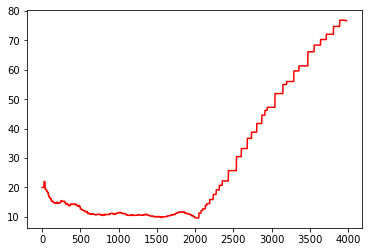

In [45]:
plt.plot(train_returns, 'r')
plt.show()